In [6]:
from omegaconf import DictConfig, OmegaConf

import torch
from torch.nn.functional import conv2d
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from functools import partial

from src import data_loader

cfg = OmegaConf.load("config.yaml")

In [7]:
# ===== Torch config =====
device = cfg.device
torch.manual_seed(cfg.seed)
torch.set_default_dtype(getattr(torch, cfg.tensor_dtype))

# ===== Data Loading =====
train_loader = data_loader.get_loader(cfg)

## Sobel Filter Histogram

In [7]:
# Define Sobel filter kernels
sobel_x = (
    torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32)
    .unsqueeze_(0)
    .unsqueeze_(0)
)
sobel_y = (
    torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32)
    .unsqueeze_(0)
    .unsqueeze_(0)
)

In [8]:
grad_cnt_xs = []
grad_cnt_ys = []
for batch_idx, (img_batch, gt_batch) in enumerate(tqdm(train_loader), start=1):
    gt_batch = gt_batch.unsqueeze_(1).to(cfg.device)
    grad_x = conv2d(gt_batch, sobel_x)
    grad_y = conv2d(gt_batch, sobel_y)
    # grad_x = grad_x - grad_y
    # grad_y = grad_y - grad_x
    grad_cnt_xs.extend(x.count_nonzero().item() for x in grad_x.flatten(2))
    grad_cnt_ys.extend(y.count_nonzero().item() for y in grad_y.flatten(2))

100%|██████████| 10/10 [00:01<00:00,  9.46it/s]


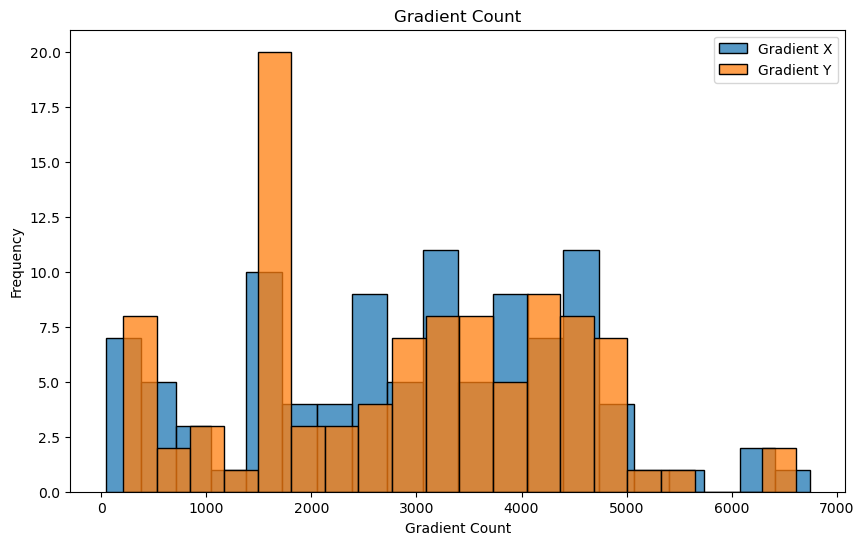

In [9]:
# Plot
# sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Gradient Count")
ax.set_xlabel("Gradient Count")
ax.set_ylabel("Frequency")
sns.histplot(grad_cnt_xs, ax=ax, label="Gradient X", bins=20)
sns.histplot(grad_cnt_ys, ax=ax, label="Gradient Y", bins=20)
ax.legend()

Text(0.5, 1.0, 'Original Image')

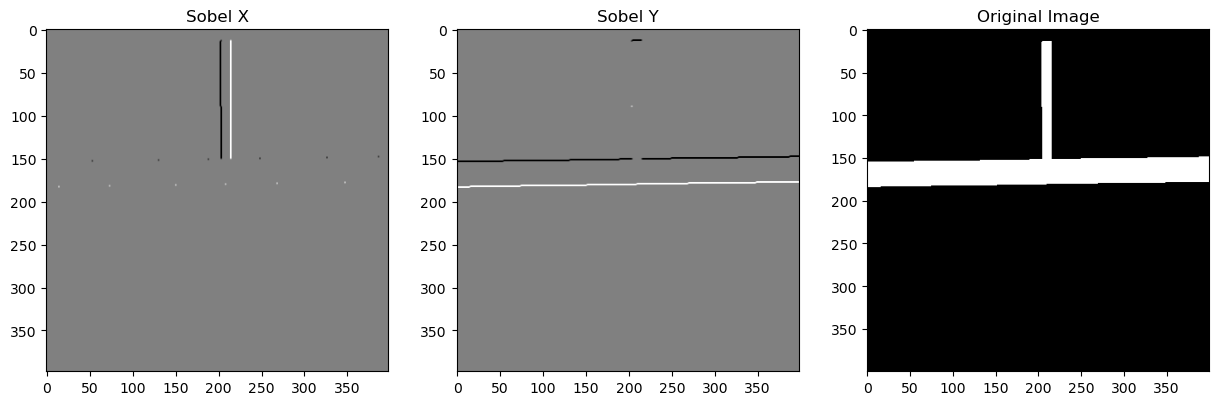

In [10]:
image = 1
gt = gt_batch[image, 0, :, :]
grad_x1 = grad_x[image, 0, :, :]
grad_y1 = grad_y[image, 0, :, :]
# Apply Sobel filter using convolution
gt = gt.unsqueeze_(0).unsqueeze_(0)

# Combine gradients to get the magnitude
# gradient_magnitude = torch.sqrt(gradient_x.pow(2) + gradient_y.pow(2))

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(grad_x1.squeeze(0).squeeze(0).cpu(), cmap="gray")
ax[0].set_title("Sobel X")
ax[1].imshow(grad_y1.squeeze(0).squeeze(0).cpu(), cmap="gray")
ax[1].set_title("Sobel Y")
ax[2].imshow(gt.squeeze(0).squeeze(0).cpu(), cmap="gray")
ax[2].set_title("Original Image")

## Filters for input data

In [78]:
# Define Sobel filter kernels
sobel_x = (
    torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32)
)
sobel_x = sobel_x.repeat(3, 1, 1).unsqueeze_(1)
sobel_y = (
    torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32)
    .unsqueeze_(0)
)
sobel_y = sobel_y.repeat(3, 1, 1).unsqueeze_(1)

In [5]:
img = train_loader.dataset[0][0].unsqueeze(0)
print(img.shape, sobel_x.shape)
grad_x = conv2d(img, sobel_x, groups=3)
grad_x.shape

NameError: name 'train_loader' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


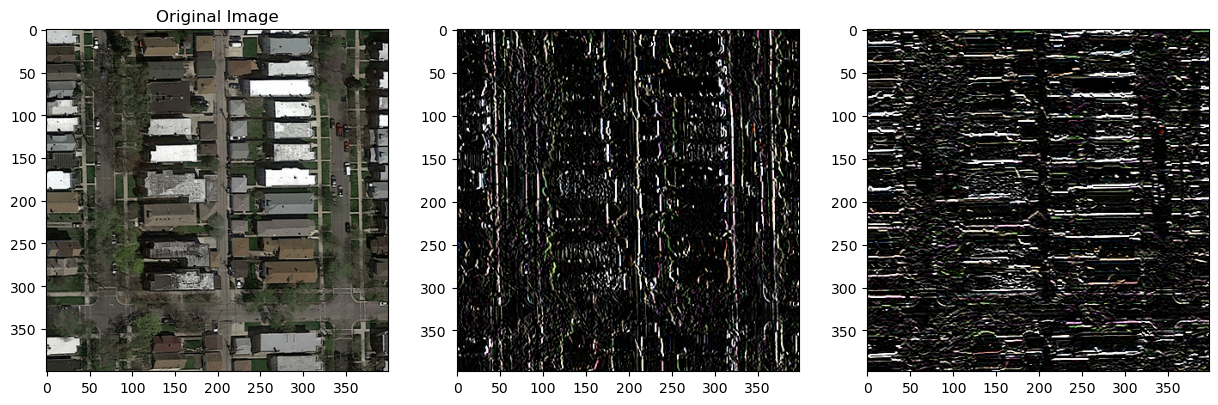

In [79]:
from matplotlib.pyplot import imshow
img = train_loader.dataset[0][0].unsqueeze(0)
grad_x = conv2d(img, sobel_x, groups=3)
grad_y = conv2d(img, sobel_y, groups=3)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img[0].permute(1, 2, 0).cpu(), cmap="gray")
ax[0].set_title("Original Image")
ax[1].imshow(grad_x.squeeze(0).permute(1, 2, 0).cpu(), cmap="gray")
ax[2].imshow(grad_y.squeeze(0).permute(1, 2, 0).cpu(), cmap="gray")


## Make some MF treeessss

Text(0.5, 1.0, 'Sobel Filter')

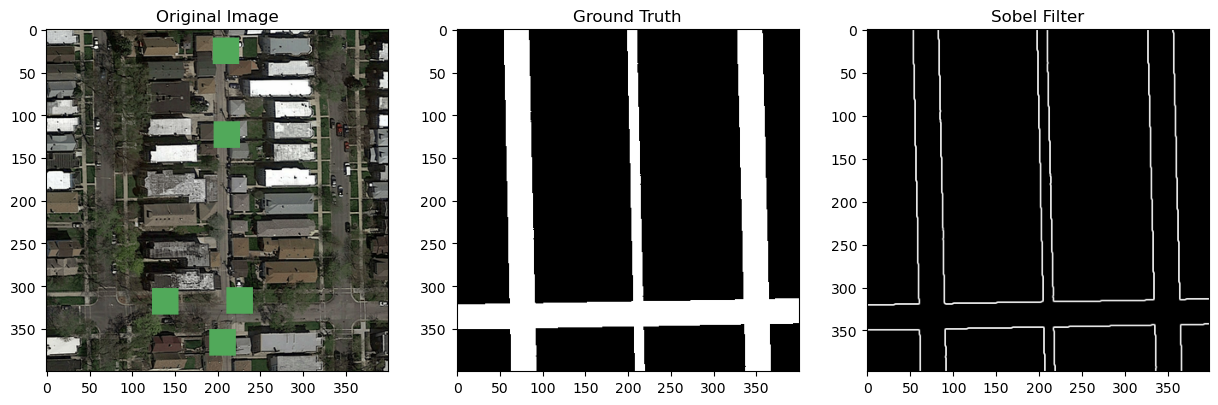

In [203]:
# Define Sobel filter kernels
sobel_x = (
    torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32)
    .unsqueeze_(0)
    .unsqueeze_(0)
)
sobel_y = (
    torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32)
    .unsqueeze_(0)
    .unsqueeze_(0)
)

obs_size = (30, 30)
num_obs = 5

img = train_loader.dataset[0][0]
gt = train_loader.dataset[0][1]
grad_x = conv2d(torch.unsqueeze(gt, 0), sobel_x)
grad_y = conv2d(torch.unsqueeze(gt, 0), sobel_y)
sobel = torch.sqrt(grad_x.pow(2) + grad_y.pow(2)).squeeze_(0)

# get indexes of non-zero elements
ids = torch.nonzero(sobel)

# pick num_obs random indexes
obs_ids = ids[torch.randint(0, len(ids), (num_obs,))]

# pick a random color 
color = np.random.uniform(0, 1, (3,))

# replace pixels around the index with 0
for channel in range(3):
    for i in range(-obs_size[0] // 2, obs_size[0] // 2 + 1):
        for j in range(-obs_size[1] // 2, obs_size[1] // 2 + 1):
            for idx in obs_ids:
                # check if the index is within the image
                if idx[0] + i < img.shape[1] and idx[1] + j < img.shape[2]:
                    img[channel, idx[0] + i, idx[1] + j] = color[channel]


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img.permute(1, 2, 0).cpu(), cmap="gray")
ax[0].set_title("Original Image")
ax[1].imshow(gt.cpu(), cmap="gray")
ax[1].set_title("Ground Truth")
ax[2].imshow(sobel.cpu(), cmap="gray")
ax[2].set_title("Sobel Filter")

In [136]:
color

tensor([0, 0, 0])